# Fast Agent - 快速构建一个 SQL Agent！

<img src="./assets/LC_L1_top.png" align="left" width="700">



这一部分我会带大家构建一个 ReAct 架构的 agent，可以通过调用 tool，进行 sql 的查询
- 使用Chinook（音乐商店）作为示例数据库
- 这个 Agent 未被提供相关的 Schema（它必须自行摸索出来！）
- 注意 - 在实际生产环境中，您需要添加更多的安全措施！
- 先在编辑器中运行，然后再在 Agent 调试器中运行！

## 初始化
加载并检查所需的环境变量

In [ ]:
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs

# 从 .env 加载环境变量
load_dotenv()

# 检查并打印结果
doublecheck_env(".env")  # 检查环境变量
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # 检查包

DASHSCOPE_API_KEY=****931f
DASHSCOPE_BASE_URL=****e/v1
LANGSMITH_API_KEY=****ef8f
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****s-56
LANGSMITH_ENDPOINT=****.com
Python 3.13.5 satisfies requires-python: >=3.11,<3.14
package                | required | installed | status | path                                                      
---------------------- | -------- | --------- | ------ | ----------------------------------------------------------
langgraph              | >=1.0.0  | 1.0.5     | ✅ OK   | /opt/anaconda3/envs/langchain/lib/python3.13/site-packages
langchain              | >=1.0.0  | 1.1.0     | ✅ OK   | /opt/anaconda3/envs/langchain/lib/python3.13/site-packages
langchain-core         | >=1.0.0  | 1.2.2     | ✅ OK   | /opt/anaconda3/envs/langchain/lib/python3.13/site-packages
langchain-openai       | >=1.0.0  | 1.1.4     | ✅ OK   | /opt/anaconda3/envs/langchain/lib/python3.13/site-packages
langchain-anthropic    | >=1.0.0  | 1.3.0     | ✅ OK   | /opt/anaconda3/envs/langchain/lib

导入实例数据库

In [8]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

## 定义上下文信息，工具与系统提示词

定义运行时上下文，为Agent和tools提供数据库访问。

In [10]:
from dataclasses import dataclass
from langchain_community.utilities import SQLDatabase

# 定义上下文结构以支持依赖注入
@dataclass
class RuntimeContext:
    """运行时上下文，保存数据库连接供Agent和tools使用。"""
    db: SQLDatabase

Context（上下文）是为 Agent 提供正确信息和工具的方式

<b>⚠️ 安全提示：</b> 此演示未对 LLM 生成的命令进行过滤。在生产环境中，你应当限制 LLM 生成命令的范围。⚠️   

该tool将连接数据库，注意使用 `get_runtime` 访问图的**运行时上下文**。

In [14]:
from langchain.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """执行SQL查询并返回结果。"""
    runtime = get_runtime(RuntimeContext)   # 取出运行时上下文
    db = runtime.context.db                 # 获取数据库连接
    try:
        return db.run(query)                # 进行数据库查询
    except Exception as e:
        return f"执行查询时出错: {e}"

添加System_prompt以定义Agent的行为。

In [15]:
SYSTEM_PROMPT = """你是一名严谨的 SQLite 分析师。

规则：
- 逐步思考。
- 如需数据,请使用名为“execute_sql”的工具并仅执行一个 SELECT 查询。
- 仅读取数据，禁止执行 INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE 操作。
- 输出结果最多限制为 5 行，除非用户明确另有要求。
- 如果工具返回“执行查询时出错:”,请修改 SQL 语句并再次尝试。
- 优先明确列出列名；避免使用 SELECT * 。
"""

## 定义模型与智能体

在创建 Agent 之前，我们先为 Agent 定义一个大脑--LLM。我们通过调用[百炼](https://modelstudio.console.alibabacloud.com/?tab=doc#/doc/?type=model&url=2840914)的 api 来创建并调用模型。

In [16]:
from langchain_qwq import ChatQwen
import os
model=ChatQwen(
    model="qwen3-max", 
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    )
#测试一下模型是否创建成功
model.invoke("Bonjour!")


AIMessage(content="Bonjour ! 😊  \nComment puis-je vous aider aujourd'hui ?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 10, 'total_tokens': 24, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'dashscope', 'model_name': 'qwen3-max', 'system_fingerprint': None, 'id': 'chatcmpl-581def01-2f1f-9760-8108-3ac424832ef7', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b50ee-ed82-7b82-946b-4da7adec71aa-0', usage_metadata={'input_tokens': 10, 'output_tokens': 14, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})

现在可以创建你的Agent了！添加model, tools, a prompt, and the runtime access,然后即可运行！你可以从Langchain 官网的[integrations](https://docs.langchain.com/oss/python/integrations/providers)列表中选择多种Agents。

对于 qwen 模型，我一般会选择 [langchain_qwq](https://docs.langchain.com/oss/python/integrations/chat/qwen) 这个包

In [17]:
from langchain.agents import create_agent

agent=create_agent(
    model=model,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

下面展示Agent的 ReAct 循环。

ReAct:语言模型中推理和行为的协同作用(Reasoning + Acting，推理 + 行动)。
- Reason
- Action
- Observation

Built with LangGraph:Persistence、Streaming、Interrupts (Human-In-The-Loop)、Tracing (LangSmith Observability & Evals)、Deployme

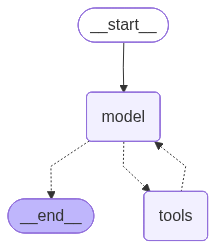

In [21]:
from IPython.display import display, Image
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

运行一些查询，注意：
- Agent并不知道数据库 schema，需要自行探索。
- Agent可能会犯错！通过返回的错误信息，它可以自我纠正查询。
- 注意你是使用 `agent.stream` 调用Agent的。
    - 这个命令与 `pretty_print` 会展示Model与Tools之间传递的**消息**。
- 注意Agent在不同调用之间不会记住 schema……稍后再讲！

## 调用智能体

In [22]:
question="哪张表的条目数量最多？"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

哪张表的条目数量最多？
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_31839979270b4d80a61799f2)
 Call ID: call_31839979270b4d80a61799f2
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_c77d914834f14f6db7bb5367)
 Call ID: call_c77d914834f14f6db7bb5367
  Args:
    query: SELECT 'Album' AS table_name, COUNT(*) AS row_count FROM Album
UNION ALL
SELECT 'Artist', COUNT(*) FROM Artist
UNION ALL
SELECT 'Customer', COUNT(*) FROM Customer
UNION ALL
SELECT 'Employee', COUN

In [23]:
question="请列出所有的表名。"
for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

请列出所有的表名。
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_0f7fbb8122bb407dbc8f3ab8)
 Call ID: call_0f7fbb8122bb407dbc8f3ab8
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

数据库中包含以下表：

1. Album  
2. Artist  
3. Customer  
4. Employee  
5. Genre  
6. Invoice  
7. InvoiceLine  
8. MediaType  
9. Playlist  
10. PlaylistTrack  
11. Track


In [24]:
question = "#哪个流派的曲目平均时长最长？"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

#哪个流派的曲目平均时长最长？
================================== Ai Message ==================================

我需要找出哪个流派的曲目平均时长最长。首先，我需要了解数据库中有哪些表以及它们的结构，特别是包含曲目信息和流派信息的表。
Tool Calls:
  execute_sql (call_5d7c39205755437cba806f69)
 Call ID: call_5d7c39205755437cba806f69
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

我看到数据库中有多个表，其中与问题相关的可能是 `Track` 表（包含曲目信息）和 `Genre` 表（包含流派信息）。让我先查看这两个表的结构。
Tool Calls:
  execute_sql (call_c6fd5247e10f400eace1253a)
 Call ID: call_c6fd5247e10f400eace1253a
  Args:
    query: PRAGMA table_info(Track);
============================